# MLP GenCode 
MLP_GenCode_trying to fix bugs.  
NEURONS=128 and K={1,2,3}.  


In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-20 16:22:13 EDT


In [2]:
PC_TRAINS=8 # 8000
NC_TRAINS=8 # 8000
PC_TESTS=2 # 8000
NC_TESTS=2 # 8000   
PC_LENS=(200,99000)
NC_LENS=(200,99000)    
PC_LENS=(200,4000)
NC_LENS=(200,4000)   
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.01
EPOCHS=500 # 1000 # 200
SPLITS=5
FOLDS=1   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel-112"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel-112"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [5]:
PC_FILENAME='gencode.v26.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v26.lncRNA_transcripts.fa.gz'
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [6]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 106143
NC seqs loaded: 48752
2021-07-20 16:22:39 EDT


## Data Prep

In [7]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_length_filter(pcdf,PC_LENS))
nc_all = dataframe_extract_sequence(
    dataframe_length_filter(ncdf,NC_LENS))

pc_all=['CAAAA','CCCCC','AAAAA','AAACC','CCCAA','CAAAA','CCCCC','AACAA','AAACC','CCCAA']
nc_all=['GGGGG','TTTTT','GGGTT','GGGTG','TTGTG','GGGGG','TTTTT','GGTTT','GGGTG','TTGTG']

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-20 16:22:40 EDT
PC seqs pass filter: 10
NC seqs pass filter: 10


In [8]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None
print("First PC train",pc_train[0])
print("First PC test",pc_test[0])

PC train, NC train: 8 8
PC test, NC test: 2 2
First PC train CAAAA
First PC test AAACC


In [9]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    for i in range(0,len0):
        all_labels[i*2] = L0[i]
        all_seqs[i*2] = S0[i]
        all_labels[i*2+1] = L1[i]
        all_seqs[i*2+1] = S1[i]
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:8])
print(y[:8])
# Tests:
show_time()

['GGGGG' 'CAAAA' 'TTTTT' 'CCCCC' 'GGGTT' 'AAAAA' 'GGGTG' 'AAACC']
[0 1 0 1 0 1 0 1]
2021-07-20 16:22:40 EDT


In [10]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[:5])
show_time()

[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.30769231 0.07692308 0.61538462 0.         0.27272727 0.
  0.         0.         0.09090909 0.         0.         0.
  0.         0.         0.63636

## Neural network

In [11]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    #mycallbacks = [ModelCheckpoint(
    #    filepath=MODELPATH, save_best_only=True, 
    #    monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    splitter = KFold(n_splits=SPLITS,shuffle=True) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    # callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-07-20 16:22:40 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/500
1/1 [==============================] - 22s 22s/step - loss: 0.6692 - accuracy: 0.5833 - val_loss: 0.7917 - val_accuracy: 0.2500
Epoch 2/500
1/1 [==============================] - 0s 59ms/step - loss: 0.6733 - accuracy: 0.5833 - val_loss: 0.7314 - val_accuracy: 0.2500
Epoch 3/500
1/1 [==============================] - 0s 104ms/step - loss: 0.6846 - accuracy: 0.5833 - val_loss: 0.7263 - val_accuracy: 0.2500
Epoch 4/500
1/1 [==============================] - 0s 55ms/step - loss: 0.6838 - accuracy: 0.5000 - val_loss: 0.7471 - val_accuracy: 0.2500
Epoch 5/500
1/1 [==============================] - 0s 102ms/step - loss: 0.7028 - accuracy: 0.5833 - val_loss: 0.7815 - val_accuracy: 0.2500
Epoch 6/500
1/1 [==============================] - 0s 64ms/step - loss: 0.6831 - accuracy: 0.5833 - val_loss: 0.8181 - val_accuracy: 0.2500
Epoch 7/500
1/1 [==============================] - 0s 109ms/step - loss: 0.6957 - accuracy:

1/1 [==============================] - 0s 75ms/step - loss: 0.6613 - accuracy: 0.5833 - val_loss: 0.8031 - val_accuracy: 0.2500
Epoch 59/500
1/1 [==============================] - 0s 78ms/step - loss: 0.6633 - accuracy: 0.5833 - val_loss: 0.8033 - val_accuracy: 0.2500
Epoch 60/500
1/1 [==============================] - 0s 65ms/step - loss: 0.6665 - accuracy: 0.5833 - val_loss: 0.8038 - val_accuracy: 0.2500
Epoch 61/500
1/1 [==============================] - 0s 51ms/step - loss: 0.6538 - accuracy: 0.5833 - val_loss: 0.8051 - val_accuracy: 0.2500
Epoch 62/500
1/1 [==============================] - 0s 45ms/step - loss: 0.6753 - accuracy: 0.6667 - val_loss: 0.8097 - val_accuracy: 0.2500
Epoch 63/500
1/1 [==============================] - 0s 49ms/step - loss: 0.6382 - accuracy: 0.6667 - val_loss: 0.8151 - val_accuracy: 0.2500
Epoch 64/500
1/1 [==============================] - 0s 39ms/step - loss: 0.6443 - accuracy: 0.5833 - val_loss: 0.8149 - val_accuracy: 0.2500
Epoch 65/500
1/1 [========

1/1 [==============================] - 0s 93ms/step - loss: 0.6073 - accuracy: 0.6667 - val_loss: 0.8793 - val_accuracy: 0.2500
Epoch 117/500
1/1 [==============================] - 0s 57ms/step - loss: 0.6005 - accuracy: 0.6667 - val_loss: 0.8711 - val_accuracy: 0.2500
Epoch 118/500
1/1 [==============================] - 0s 45ms/step - loss: 0.6108 - accuracy: 0.6667 - val_loss: 0.8646 - val_accuracy: 0.2500
Epoch 119/500
1/1 [==============================] - 0s 37ms/step - loss: 0.6094 - accuracy: 0.6667 - val_loss: 0.8643 - val_accuracy: 0.2500
Epoch 120/500
1/1 [==============================] - 0s 39ms/step - loss: 0.6083 - accuracy: 0.7500 - val_loss: 0.8700 - val_accuracy: 0.2500
Epoch 121/500
1/1 [==============================] - 0s 40ms/step - loss: 0.6066 - accuracy: 0.7500 - val_loss: 0.8702 - val_accuracy: 0.2500
Epoch 122/500
1/1 [==============================] - 0s 31ms/step - loss: 0.5982 - accuracy: 0.7500 - val_loss: 0.8721 - val_accuracy: 0.2500
Epoch 123/500
1/1 [=

Epoch 174/500
1/1 [==============================] - 0s 37ms/step - loss: 0.5457 - accuracy: 0.7500 - val_loss: 0.9587 - val_accuracy: 0.2500
Epoch 175/500
1/1 [==============================] - 0s 36ms/step - loss: 0.5502 - accuracy: 0.7500 - val_loss: 0.9609 - val_accuracy: 0.2500
Epoch 176/500
1/1 [==============================] - 0s 62ms/step - loss: 0.5458 - accuracy: 0.7500 - val_loss: 0.9557 - val_accuracy: 0.2500
Epoch 177/500
1/1 [==============================] - 0s 37ms/step - loss: 0.5426 - accuracy: 0.7500 - val_loss: 0.9608 - val_accuracy: 0.2500
Epoch 178/500
1/1 [==============================] - 0s 67ms/step - loss: 0.5369 - accuracy: 0.8333 - val_loss: 0.9739 - val_accuracy: 0.2500
Epoch 179/500
1/1 [==============================] - 0s 50ms/step - loss: 0.5361 - accuracy: 0.7500 - val_loss: 0.9667 - val_accuracy: 0.2500
Epoch 180/500
1/1 [==============================] - 0s 42ms/step - loss: 0.5301 - accuracy: 0.8333 - val_loss: 0.9614 - val_accuracy: 0.2500
Epoch 

1/1 [==============================] - 0s 52ms/step - loss: 0.4988 - accuracy: 0.8333 - val_loss: 0.9355 - val_accuracy: 0.2500
Epoch 232/500
1/1 [==============================] - 0s 33ms/step - loss: 0.4720 - accuracy: 0.8333 - val_loss: 0.9481 - val_accuracy: 0.2500
Epoch 233/500
1/1 [==============================] - 0s 39ms/step - loss: 0.4697 - accuracy: 0.8333 - val_loss: 0.9633 - val_accuracy: 0.2500
Epoch 234/500
1/1 [==============================] - 0s 38ms/step - loss: 0.4273 - accuracy: 0.8333 - val_loss: 0.9871 - val_accuracy: 0.2500
Epoch 235/500
1/1 [==============================] - 0s 71ms/step - loss: 0.4866 - accuracy: 0.8333 - val_loss: 0.9861 - val_accuracy: 0.2500
Epoch 236/500
1/1 [==============================] - 0s 51ms/step - loss: 0.5058 - accuracy: 0.8333 - val_loss: 0.9766 - val_accuracy: 0.2500
Epoch 237/500
1/1 [==============================] - 0s 55ms/step - loss: 0.4592 - accuracy: 0.8333 - val_loss: 0.9624 - val_accuracy: 0.2500
Epoch 238/500
1/1 [=

Epoch 289/500
1/1 [==============================] - 0s 38ms/step - loss: 0.4165 - accuracy: 0.8333 - val_loss: 0.8411 - val_accuracy: 0.2500
Epoch 290/500
1/1 [==============================] - 0s 37ms/step - loss: 0.4674 - accuracy: 0.8333 - val_loss: 0.8364 - val_accuracy: 0.2500
Epoch 291/500
1/1 [==============================] - 0s 53ms/step - loss: 0.4183 - accuracy: 0.7500 - val_loss: 0.8581 - val_accuracy: 0.2500
Epoch 292/500
1/1 [==============================] - 0s 85ms/step - loss: 0.4441 - accuracy: 0.7500 - val_loss: 0.9040 - val_accuracy: 0.2500
Epoch 293/500
1/1 [==============================] - 0s 109ms/step - loss: 0.4349 - accuracy: 0.8333 - val_loss: 0.9228 - val_accuracy: 0.2500
Epoch 294/500
1/1 [==============================] - 0s 55ms/step - loss: 0.4230 - accuracy: 0.8333 - val_loss: 0.9422 - val_accuracy: 0.2500
Epoch 295/500
1/1 [==============================] - 0s 43ms/step - loss: 0.4415 - accuracy: 0.7500 - val_loss: 0.9526 - val_accuracy: 0.2500
Epoch

Epoch 347/500
1/1 [==============================] - 0s 36ms/step - loss: 0.3113 - accuracy: 0.9167 - val_loss: 0.8942 - val_accuracy: 0.2500
Epoch 348/500
1/1 [==============================] - 0s 40ms/step - loss: 0.3049 - accuracy: 0.8333 - val_loss: 0.9051 - val_accuracy: 0.2500
Epoch 349/500
1/1 [==============================] - 0s 37ms/step - loss: 0.3440 - accuracy: 0.9167 - val_loss: 0.8893 - val_accuracy: 0.2500
Epoch 350/500
1/1 [==============================] - 0s 36ms/step - loss: 0.3426 - accuracy: 0.8333 - val_loss: 0.8408 - val_accuracy: 0.2500
Epoch 351/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3796 - accuracy: 0.8333 - val_loss: 0.7851 - val_accuracy: 0.2500
Epoch 352/500
1/1 [==============================] - 0s 34ms/step - loss: 0.4003 - accuracy: 0.8333 - val_loss: 0.7817 - val_accuracy: 0.2500
Epoch 353/500
1/1 [==============================] - 0s 34ms/step - loss: 0.3818 - accuracy: 0.8333 - val_loss: 0.8283 - val_accuracy: 0.2500
Epoch 

1/1 [==============================] - 0s 66ms/step - loss: 0.3184 - accuracy: 0.8333 - val_loss: 0.8375 - val_accuracy: 0.2500
Epoch 405/500
1/1 [==============================] - 0s 77ms/step - loss: 0.3770 - accuracy: 0.8333 - val_loss: 0.8762 - val_accuracy: 0.2500
Epoch 406/500
1/1 [==============================] - 0s 67ms/step - loss: 0.3011 - accuracy: 0.8333 - val_loss: 0.8706 - val_accuracy: 0.2500
Epoch 407/500
1/1 [==============================] - 0s 59ms/step - loss: 0.3287 - accuracy: 0.8333 - val_loss: 0.8493 - val_accuracy: 0.2500
Epoch 408/500
1/1 [==============================] - 0s 36ms/step - loss: 0.3457 - accuracy: 0.8333 - val_loss: 0.7970 - val_accuracy: 0.2500
Epoch 409/500
1/1 [==============================] - 0s 50ms/step - loss: 0.3393 - accuracy: 0.8333 - val_loss: 0.7206 - val_accuracy: 0.5000
Epoch 410/500
1/1 [==============================] - 0s 57ms/step - loss: 0.3255 - accuracy: 0.8333 - val_loss: 0.6823 - val_accuracy: 0.5000
Epoch 411/500
1/1 [=

Epoch 462/500
1/1 [==============================] - 0s 41ms/step - loss: 0.3295 - accuracy: 0.8333 - val_loss: 0.7358 - val_accuracy: 0.2500
Epoch 463/500
1/1 [==============================] - 0s 39ms/step - loss: 0.2876 - accuracy: 0.8333 - val_loss: 0.7232 - val_accuracy: 0.2500
Epoch 464/500
1/1 [==============================] - 0s 43ms/step - loss: 0.2750 - accuracy: 0.8333 - val_loss: 0.7053 - val_accuracy: 0.5000
Epoch 465/500
1/1 [==============================] - 0s 32ms/step - loss: 0.2392 - accuracy: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 466/500
1/1 [==============================] - 0s 43ms/step - loss: 0.3222 - accuracy: 0.8333 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 467/500
1/1 [==============================] - 0s 38ms/step - loss: 0.3036 - accuracy: 0.8333 - val_loss: 0.6546 - val_accuracy: 0.5000
Epoch 468/500
1/1 [==============================] - 0s 56ms/step - loss: 0.2824 - accuracy: 0.9167 - val_loss: 0.6441 - val_accuracy: 0.5000
Epoch 

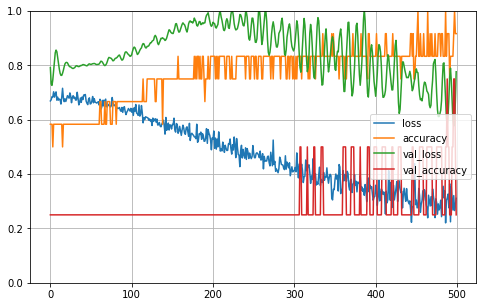

In [13]:
show_time()
last_model = do_cross_validation(Xfrq,y)

In [14]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
Prepare...
2021-07-20 16:23:38 EDT
Extract K-mer features...
2021-07-20 16:23:38 EDT
Plot...
2021-07-20 16:23:38 EDT


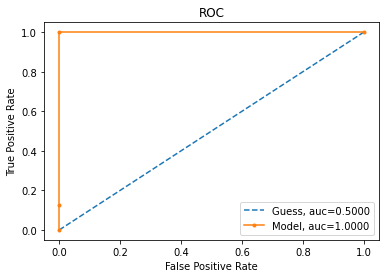

AUC: 100.00%
accuracy: 68.75%
2021-07-20 16:23:39 EDT


In [15]:
print("Accuracy on training data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq,y)
show_test_accuracy(last_model,Xfrq,y)
show_time()

Accuracy on test data.
Prepare...
2021-07-20 16:23:39 EDT
Extract K-mer features...
2021-07-20 16:23:39 EDT
Plot...
2021-07-20 16:23:39 EDT


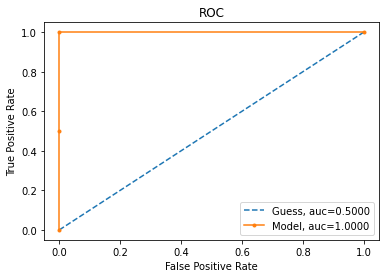

AUC: 100.00%
accuracy: 75.00%
2021-07-20 16:23:40 EDT


In [16]:
print("Accuracy on test data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_test,nc_test)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq,y)
show_test_accuracy(last_model,Xfrq,y)
show_time()